In [7]:
# the demo .ipynb suggests Python 3.10.12 
import torch
import torchvision
import torchlens as tl

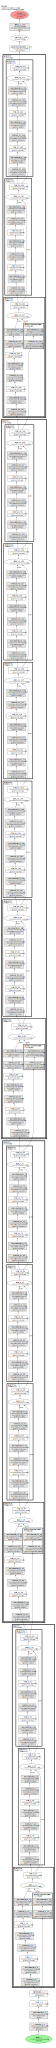

Log of ResNet forward pass:
	Random seed: 1705450137
	Time elapsed: 3.575s (3.551s spent logging)
	Structure:
		- purely feedforward, no recurrence
		- with branching
		- no conditional (if-then) branching
		- contains 106 buffer layers
		- 150 total modules
	Tensor info:
		- 283 total tensors (144.1 MB) computed in forward pass.
		- 283 tensors (144.1 MB) with saved activations.
	Parameters: 107 parameter operations (25557032 params total; 97.5 MB)
	Module Hierarchy:
		conv1
		bn1
		relu
		maxpool
		layer1
		    layer1.0
		        layer1.0.conv1
		        layer1.0.bn1
		        layer1.0.relu:1
		        layer1.0.conv2
		        layer1.0.bn2
		        layer1.0.relu:2
		        layer1.0.conv3
		        layer1.0.bn3
		        layer1.0.downsample
		            layer1.0.downsample.0, layer1.0.downsample.1
		        layer1.0.relu:3
		    layer1.1
		        layer1.1.conv1, layer1.1.bn1, layer1.1.relu:1, layer1.1.conv2, layer1.1.bn2, layer1.1.relu:2, layer1.1.conv3, layer1.1.bn3, 
		        l

In [2]:
# load in pre-trained model
model = torchvision.models.resnet50(weights="IMAGENET1K_V1")
model.eval()

# dummy input
x = torch.rand(1, 3, 224, 224)
model_history = tl.log_forward_pass(model, x, layers_to_save='all', vis_opt='unrolled')
print(model_history)

# ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH
# i need to 'brew install graphviz', that's my fault

Downloading: "https://github.com/harvard-visionlab/lrm-steering/zipball/main" to /Users/aim/.cache/torch/hub/main.zip
==> Loading weights for alexnet_lrm3, hash_id=63ab1b3b06
https://s3.us-east-1.wasabisys.com/visionlab-projects/dnn_feedback_dev/logs/set15/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps/28453e80-c5e5-4d76-bc81-99c5fade39ff/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps_final_weights-63ab1b3b06.pth
local_filename: /Users/aim/.cache/torch/hub/set15_alexnet_torchvision_imagenet1k_lrm_3back_2steps_final_weights-63ab1b3b06.pth
<All keys matched successfully>


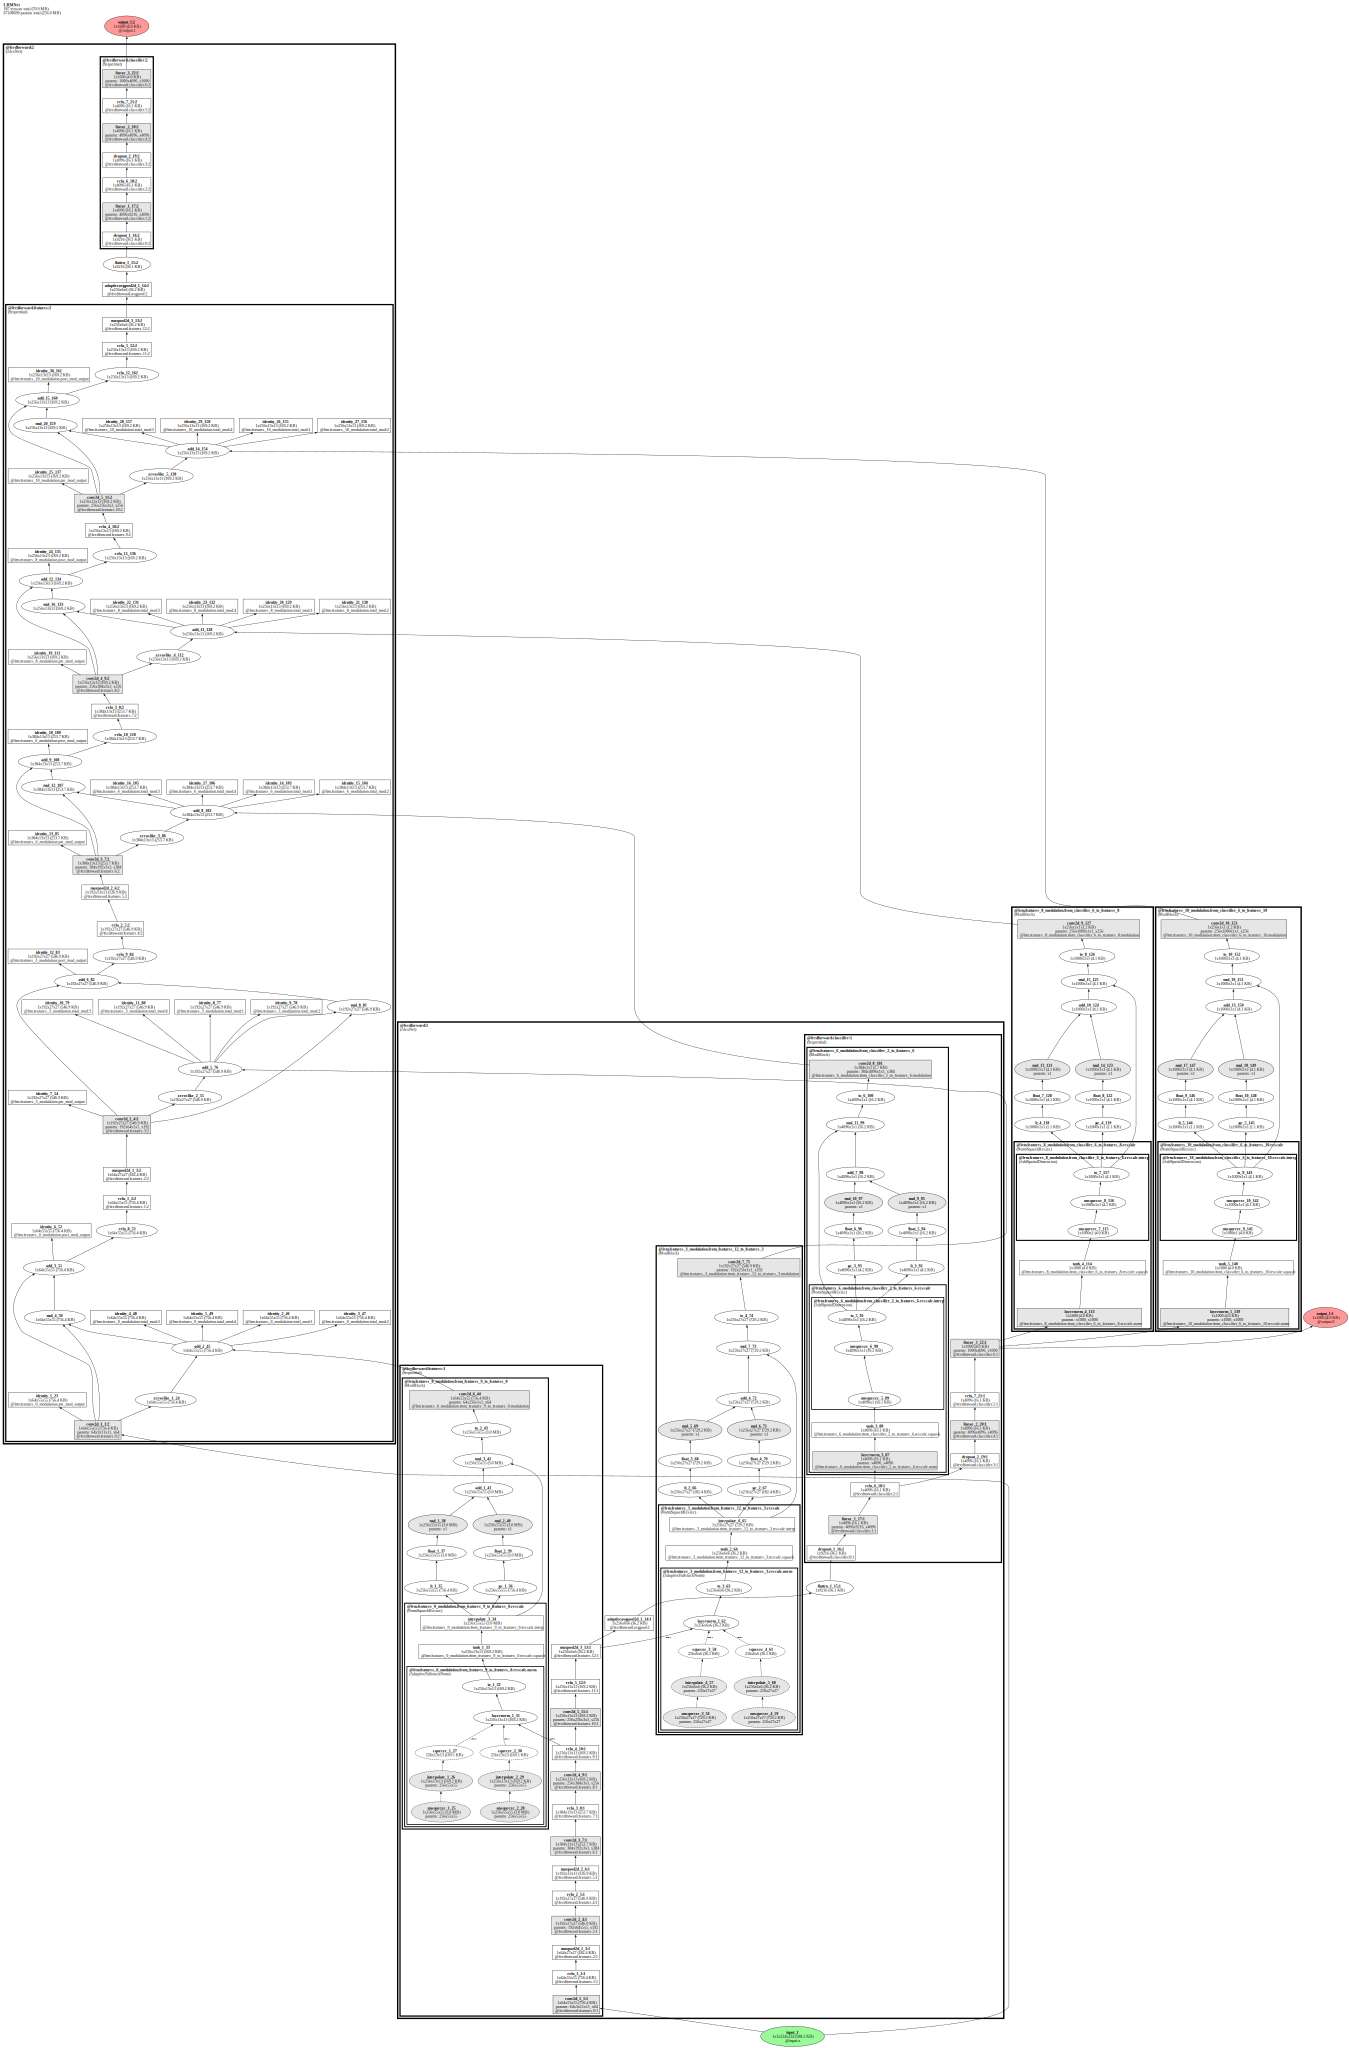

Log of LRMNet forward pass:
	Random seed: 3218663690
	Time elapsed: 1.518s (1.495s spent logging)
	Structure:
		- recurrent (at most 2 loops)
		- with branching
		- no conditional (if-then) branching
		- 69 total modules
	Tensor info:
		- 187 total tensors (70.9 MB) computed in forward pass.
		- 187 tensors (70.9 MB) with saved activations.
	Parameters: 34 parameter operations (67108690 params total; 256.0 MB)
	Module Hierarchy:
		feedforward:1
		    feedforward.features:1
		        feedforward.features.0:1
		        feedforward.features.1:1
		        feedforward.features.2:1
		        feedforward.features.3:1
		        feedforward.features.4:1
		        feedforward.features.5:1
		        feedforward.features.6:1
		        feedforward.features.7:1
		        feedforward.features.8:1
		        feedforward.features.9:1
		        feedforward.features.10:1
		        feedforward.features.11:1
		        feedforward.features.12:1
		        lrm.features_0_modulation.from_features_9_to_features_

In [3]:
# now try a more recent model
lrm, transforms = torch.hub.load('harvard-visionlab/lrm-steering', 'alexnet_lrm3', pretrained=True, steering=False, force_reload=True)
lrm.eval()

# wow, it works really well!
model_history = tl.log_forward_pass(lrm, x, layers_to_save='all', vis_opt='unrolled')
print(model_history)

In [29]:
# Supplementary Document has lots of information about the ModelHistory class
# https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-023-40807-0/MediaObjects/41598_2023_40807_MOESM1_ESM.pdf

print(f'Model name: {model_history.model_name}\n')
print(f'All layers:\n{" --> ".join([l.layer_label_short for l in model_history.layer_list])}\n')
print(f'Outputs: {model_history.output_layers}')

Model name: LRMNet

All layers:
input_1 --> conv2d_1:1 --> relu_1:1 --> maxpool2d_1:1 --> conv2d_2:1 --> relu_2:1 --> maxpool2d_2:1 --> conv2d_3:1 --> relu_3:1 --> conv2d_4:1 --> relu_4:1 --> conv2d_5:1 --> relu_5:1 --> maxpool2d_3:1 --> adaptiveavgpool2d_1:1 --> flatten_1:1 --> dropout_1:1 --> linear_1:1 --> relu_6:1 --> dropout_2:1 --> linear_2:1 --> relu_7:1 --> linear_3:1 --> conv2d_1:2 --> identity_1 --> zeroslike_1 --> unsqueeze_1 --> interpolate_1 --> squeeze_1 --> unsqueeze_2 --> interpolate_2 --> squeeze_2 --> layernorm_1 --> to_1 --> tanh_1 --> interpolate_3 --> lt_1 --> ge_1 --> float_1 --> mul_1 --> float_2 --> mul_2 --> add_1 --> mul_3 --> to_2 --> conv2d_6 --> add_2 --> identity_2 --> identity_3 --> identity_4 --> identity_5 --> mul_4 --> add_3 --> identity_6 --> relu_8 --> relu_1:2 --> maxpool2d_1:2 --> conv2d_2:2 --> identity_7 --> zeroslike_2 --> unsqueeze_3 --> interpolate_4 --> squeeze_3 --> unsqueeze_4 --> interpolate_5 --> squeeze_4 --> layernorm_2 --> to_3 --> tan

In [37]:
# how to get the actual model activations
act = model_history['relu_6:2'].tensor_contents
act = act.detach().numpy()

# this is so easy, why am i not using this?
print(f'layer fc6 activation shape: {act.shape}')

layer fc6 activation shape: (1, 4096)


In [1]:
# trying out the new Recitified LpJEPA model (released 02.03.2026)
# https://t.co/CZtKHVvKT4
import torch, torch.nn as nn, torch.nn.functional as F
import math, tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
from torch.amp import GradScaler, autocast

import torchlens as tl

/Users/aim/Desktop/HVRD/workspace/torch-lens/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
'''
Building LpJEPA from scratch 
'''

# backbone
class Projector(nn.Module):
    def __init__(self, dim=512):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Linear(dim, dim),
            nn.ReLU() # Final ReLU for non-negativity
        )
    def forward(self, x):
        return self.model(x)

class RectifiedLpJEPA(nn.Module):
    def __init__(self, backbone_name="resnet18", dim=512):
        super().__init__()
        # Load backbone and remove the final classification layer
        self.backbone = timm.create_model(backbone_name, pretrained=False, num_classes=0)
        self.projector = Projector(dim=dim)

    def forward(self, x):
        feats = self.backbone(x)
        z = self.projector(feats)
        return z

# sparse prior
def sample_rgg(shape, p=1.0, mu=0.0, device='cpu'):
    """
    Samples from Rectified Generalized Gaussian: ReLU(mu + sigma * GN_p).
    p=1.0 is Rectified Product Laplace (Sparsity prior).
    """
    # sigma for unit variance of GN_p before rectification
    sigma = math.sqrt(math.gamma(1/p) / math.gamma(3/p)) / (p**(1/p))
    
    # Sample Generalized Gaussian GN_p(0, 1)
    sign = torch.empty(shape, device=device).bernoulli_(0.5) * 2 - 1
    gamma_dist = torch.distributions.Gamma(concentration=1.0/p, rate=1.0)
    g = gamma_dist.sample(shape).to(device)
    gn_samples = sign * (p * g).pow(1.0/p)
    
    return torch.relu(mu + sigma * gn_samples)

# loss function
def rdmreg_loss(z, target_samples, num_projections=256):
    B, D = z.shape
    # 1. Generate random projections (normalized)
    projections = torch.randn(num_projections, D, device=z.device)
    projections = projections / projections.norm(dim=1, keepdim=True)
    
    # 2. Project features and target samples
    proj_z = torch.matmul(z, projections.T)
    proj_target = torch.matmul(target_samples, projections.T)
    
    # 3. Sort and compute Wasserstein-2 distance
    proj_z_sorted, _ = torch.sort(proj_z, dim=0)
    proj_target_sorted, _ = torch.sort(proj_target, dim=0)
    
    return torch.mean((proj_z_sorted - proj_target_sorted)**2)

transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

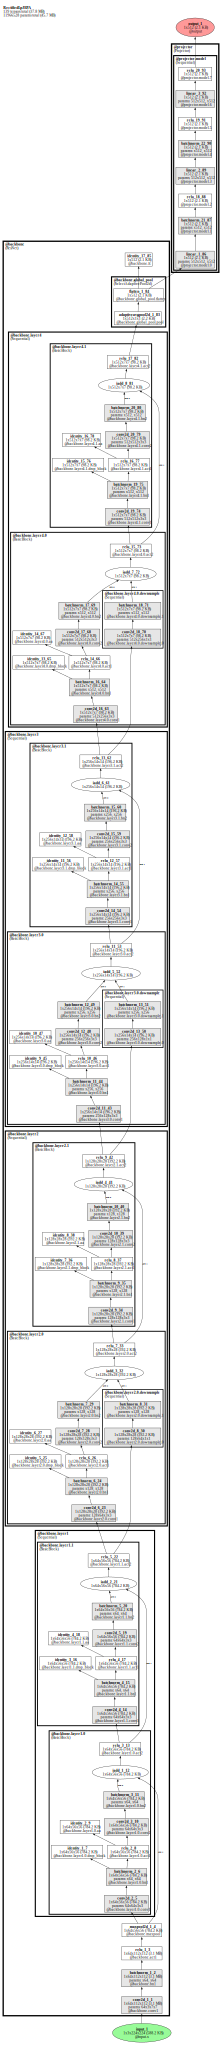

Log of RectifiedLpJEPA forward pass:
	Random seed: 870151688
	Time elapsed: 1.95s (1.937s spent logging)
	Structure:
		- purely feedforward, no recurrence
		- with branching
		- no conditional (if-then) branching
		- contains 44 buffer layers
		- 104 total modules
	Tensor info:
		- 139 total tensors (37.8 MB) computed in forward pass.
		- 139 tensors (37.8 MB) with saved activations.
	Parameters: 45 parameter operations (11966528 params total; 45.7 MB)
	Module Hierarchy:
		backbone
		    backbone.conv1
		    backbone.bn1
		    backbone.act1
		    backbone.maxpool
		    backbone.layer1
		        backbone.layer1.0
		            backbone.layer1.0.conv1, backbone.layer1.0.bn1, backbone.layer1.0.drop_block, backbone.layer1.0.act1, backbone.layer1.0.aa, backbone.layer1.0.conv2, backbone.layer1.0.bn2, backbone.layer1.0.act2
		        backbone.layer1.1
		            backbone.layer1.1.conv1, backbone.layer1.1.bn1, backbone.layer1.1.drop_block, backbone.layer1.1.act1, backbone.layer1.1.aa, backb

In [9]:
# can i use TorchLens to understand the model?
lpjepa = RectifiedLpJEPA()
lpjepa.eval()

# dummy input
x = torch.rand(1, 3, 224, 224)
model_history = tl.log_forward_pass(lpjepa, x, layers_to_save='all', vis_opt='unrolled')
print(model_history)

In [10]:
# same as with lrm, checking the architecture
print(f'Model name: {model_history.model_name}\n')
print(f'All layers:\n{" --> ".join([l.layer_label_short for l in model_history.layer_list])}\n')
print(f'Outputs: {model_history.output_layers}')

# it works! 

Model name: RectifiedLpJEPA

All layers:
input_1 --> conv2d_1 --> buffer_1 --> buffer_2 --> batchnorm_1 --> relu_1 --> maxpool2d_1 --> conv2d_2 --> buffer_3 --> buffer_4 --> batchnorm_2 --> identity_1 --> relu_2 --> identity_2 --> conv2d_3 --> buffer_5 --> buffer_6 --> batchnorm_3 --> iadd_1 --> relu_3 --> conv2d_4 --> buffer_7 --> buffer_8 --> batchnorm_4 --> identity_3 --> relu_4 --> identity_4 --> conv2d_5 --> buffer_9 --> buffer_10 --> batchnorm_5 --> iadd_2 --> relu_5 --> conv2d_6 --> buffer_11 --> buffer_12 --> batchnorm_6 --> identity_5 --> relu_6 --> identity_6 --> conv2d_7 --> buffer_13 --> buffer_14 --> batchnorm_7 --> conv2d_8 --> buffer_15 --> buffer_16 --> batchnorm_8 --> iadd_3 --> relu_7 --> conv2d_9 --> buffer_17 --> buffer_18 --> batchnorm_9 --> identity_7 --> relu_8 --> identity_8 --> conv2d_10 --> buffer_19 --> buffer_20 --> batchnorm_10 --> iadd_4 --> relu_9 --> conv2d_11 --> buffer_21 --> buffer_22 --> batchnorm_11 --> identity_9 --> relu_10 --> identity_10 --> con